# Data semantics

The project involves probing the subclass-of and instance-of ontological relations in masked language models. The ontology is used as a structured gold standard to construct negative and positive examples for the model.

The goal is therefore to evaluate whether and to what extent masked language models (such as BERT) encode ontological containment relations (is-a). This is done through probing experiments based on binary classification.

Objective is replicate results of following papers:
1. LMAOSI's paper: [Language Model Analysis for Ontology Subsumption Inference](https://arxiv.org/pdf/2302.06761)
2. PRONTO's paper: [PRONTO: Prompt-Based Detection of Semantic Containment Patterns in MLMs](https://link.springer.com/chapter/10.1007/978-3-031-77850-6_13)

In LMAOSI's paper only RoBerta model is used (because the paper aims to see improvement in model by creating a classical k-shot verbalizer), while in PRONTO's paper are both used Bert and RoBerta to test (oher to the construction of dynamic verbalizer) if the smaller model (Bert) can achieve similiar results.

In this notbeook we will experiment with both models to asses results of PRONTO's statements by changing following variable and re-running the notebook:

In [1]:
#model_name = "bert-base-uncased"
model_name = "roberta-base"

we will then evaluate both kind's of probing k-shot and dyamic probe suggested by both papers, saving all models for demo in here: 

In [2]:
models_dir = f"saved_models/{model_name}"

## 0. Setup

In [3]:
!pip install -r requirements.txt

In [4]:
import torch
import math
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn as nn
import os
import networkx as nx
from typing import Set, Dict, List, Tuple
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import json
from pathlib import Path

## 1. Load & Explore dataset

### 1.1. Load dataset

We will use the same dataset (ATOMIC-SI / GO from ontoLAMA) used in LMAOSI's paper to have a valuable comparaison between the results.

In [5]:
dataset = load_dataset("krr-oxford/OntoLAMA", "go-atomic-SI")

Small visualization to see dataset components:

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['v_sub_concept', 'v_super_concept', 'label', 'axiom'],
        num_rows: 772870
    })
    validation: Dataset({
        features: ['v_sub_concept', 'v_super_concept', 'label', 'axiom'],
        num_rows: 96608
    })
    test: Dataset({
        features: ['v_sub_concept', 'v_super_concept', 'label', 'axiom'],
        num_rows: 96610
    })
})

### 1.2. Dataset exploration

In [7]:
for i in range(3):
    print(dataset['train'][i])

{'v_sub_concept': 'cytosolic lipolysis', 'v_super_concept': 'biological process', 'label': 1, 'axiom': 'SubClassOf(<http://purl.obolibrary.org/obo/GO_0061725> <http://purl.obolibrary.org/obo/GO_0008150>)'}
{'v_sub_concept': 'mitochondrial oxoglutarate dehydrogenase complex', 'v_super_concept': 'oxidoreductase complex', 'label': 1, 'axiom': 'SubClassOf(<http://purl.obolibrary.org/obo/GO_0009353> <http://purl.obolibrary.org/obo/GO_1990204>)'}
{'v_sub_concept': 'positive regulation of protein localization', 'v_super_concept': 'regulation of localization', 'label': 1, 'axiom': 'SubClassOf(<http://purl.obolibrary.org/obo/GO_1903829> <http://purl.obolibrary.org/obo/GO_0032879>)'}


We have a format like this:
- sub: specific concept

- sup: general concept

- label:

    - 1 → relazione is-a valida

    - 0 → relazione negativa

#### 1.2.1. Split into pd-dataframe

putting dataset of train test and val as pandas datasets (this makes it easier to analyze them)

In [8]:
df_train = pd.DataFrame(dataset['train'])
df_train

,v_sub_concept,v_super_concept,label,axiom
0,cytosolic lipolysis,biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
1,mitochondrial oxoglutarate dehydrogenase complex,oxidoreductase complex,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
2,positive regulation of protein localization,regulation of localization,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
3,hemicellulose catabolic process,biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
4,positive regulation of cell morphogenesis invo...,positive regulation of biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
...,...,...,...,...
772865,positive regulation of mitotic recombination-d...,positive regulation of meiosis i spindle assem...,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
772866,aminolevulinate transaminase activity,aspartate-phenylpyruvate transaminase activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
772867,lung lobe formation,sno(s)rna metabolic process,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
772868,polysome binding,glycolate dehydrogenase activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...


In [9]:
df_test = pd.DataFrame(dataset['test'])
df_test

,v_sub_concept,v_super_concept,label,axiom
0,endonucleolytic cleavage of tricistronic rrna ...,cellular process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
1,"positive regulation of (z)-nonadeca-1,14-diene...",positive regulation of biosynthetic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
2,regulation of retrograde trans-synaptic signal...,regulation of biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
3,regulation of glutamine transport,regulation of anion transport,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
4,platelet-derived growth factor receptor-ligand...,membrane protein complex,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
...,...,...,...,...
96605,"regulation of complement activation, alternati...",regulation of melanization defense response,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96606,tubulin binding,fatz binding,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96607,coenzyme a metabolic process,signaling receptor complex adaptor activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96608,ecdysone 20-monooxygenase activity,methyl tertiary butyl ether 3-monooxygenase ac...,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...


In [10]:
df_val = pd.DataFrame(dataset['validation'])
df_val

,v_sub_concept,v_super_concept,label,axiom
0,tryparedoxin peroxidase activity,molecular function,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
1,branched-chain amino acid catabolic process to...,branched-chain amino acid catabolic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
2,gerfelin catabolic process,cellular catabolic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
3,vascular endothelial growth factor production,multicellular organismal process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
4,modification by virus of host cell cycle regul...,modulation by symbiont of host cellular process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
...,...,...,...,...
96603,corticotropin hormone secreting cell development,oxazole or thiazole metabolic process,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96604,interferon-epsilon production,quercetin 3-o-methyltransferase activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96605,protein activation cascade,"mitochondrial electron transport, cytochrome c...",0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96606,homoserine transmembrane transporter activity,benzodiazepine receptor activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...


In [11]:
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

Train: (772870, 4)
Validation: (96608, 4)
Test: (96610, 4)


#### 1.2.2. Visulize labels distribution:

In [12]:
def label_stats(df):
    return df["label"].value_counts(normalize=True)

In [13]:
print("Train label distribution:\n", label_stats(df_train))
print()
print("Validation label distribution:\n", label_stats(df_val))
print()
print("Test label distribution:\n", label_stats(df_test))

Train label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


we have perfectly even distribution, wich is good (also same exact as the paper)

#### 1.2.3. Number of unique concepts

In [14]:
def unique_concepts(df):
    return {
        "unique_sub": df["v_sub_concept"].nunique(),
        "unique_sup": df["v_super_concept"].nunique()
    }

In [15]:
print("Number of unique concepts:")
print("Train:", unique_concepts(df_train))
print("Validation:", unique_concepts(df_val))
print("Test:", unique_concepts(df_test))

Number of unique concepts:
Train: {'unique_sub': 43303, 'unique_sup': 43171}
Validation: {'unique_sub': 36575, 'unique_sup': 27989}
Test: {'unique_sub': 36395, 'unique_sup': 27958}


overlap checking:

In [16]:
overlap = set(df_train["v_sub_concept"]).intersection(set(df_train["v_super_concept"]))
print(f"Number of overlapping concepts in train set: {len(overlap)} / {unique_concepts(df_train)['unique_sup']}")
print(f"Percentage of overlapping concepts in train set: {len(overlap) / unique_concepts(df_train)['unique_sup'] * 100:.2f}%")

Number of overlapping concepts in train set: 43171 / 43171
Percentage of overlapping concepts in train set: 100.00%


also if we check overlap of super-concept and sub-concept we have that 100% of super-concepts aligns with sub-concepts

**Although all concepts appear both as sub- and super-concepts, the task remains non-trivial, since labels are assigned to ordered concept pairs, forcing the model to reason about semantic containment rather than memorising individual concepts.**

In [17]:
df_train.groupby("v_sub_concept")["label"].nunique().value_counts()

label
2    43037
1      266
Name: count, dtype: int64

This demonstrates that for all sub-concepts exixst both positive and negative examples


#### 1.2.4. Number of words per token

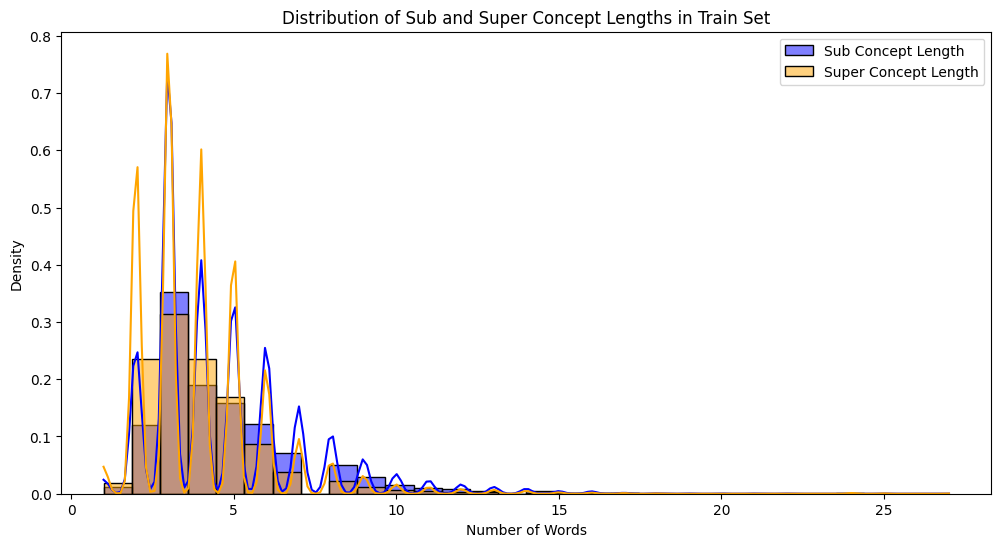

In [18]:
df_train["sub_len"] = df_train["v_sub_concept"].apply(lambda x: len(x.split()))
df_train["sup_len"] = df_train["v_super_concept"].apply(lambda x: len(x.split()))

df_train[["sub_len", "sup_len"]].describe()
plt.figure(figsize=(12, 6))
sns.histplot(df_train["sub_len"], color='blue', label='Sub Concept Length', kde=True, stat="density", bins=30)
sns.histplot(df_train["sup_len"], color='orange', label='Super Concept Length', kde=True, stat="density", bins=30)
plt.title('Distribution of Sub and Super Concept Lengths in Train Set')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.show()

In [19]:
df_train[["sub_len", "sup_len"]].describe()

,sub_len,sup_len
count,772870.000000,772870.000000
mean,4.633279,3.960198
std,2.422115,2.031670
min,1.000000,1.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,6.000000,5.000000
max,27.000000,27.000000


here we can clearly see that most of tokens are made of 5 or less words (separated by space)

## 2. Creating prompt for model

### 2.1. Prompt from PRONTO's paper:

Here we implant into the datasets the datasets varius prompts from the PRONTO paper,

having prompt directly into dataset makes it easier for train aftewards:

In [20]:
def make_prompt(row):
    if model_name.startswith("bert"):
        prompt = f"{row['v_sub_concept']} is a [MASK] of {row['v_super_concept']}."
    elif model_name.startswith("roberta"):
        prompt = f"{row['v_sub_concept']} is a <mask> of {row['v_super_concept']}."
    return prompt

**IMPORTANT:**

Initially, we experimented with one template from PROMPTO's paper list:

$$h_2 = \text{<C> is a [MASK] of <D>}$$

those are all prompts used in PRONTO's paper:

| Template Type   | Template ID | Prompt Example |
|-----------------|-------------|----------------|
| Hard Templates  | h_1         | Paris is [MASK] of capital |
| Hard Templates  | h_2         | Paris is a [MASK] of capital |
| Hard Templates  | h_3         | Paris [MASK] capital |
| Hard Templates  | h_4         | Paris is [MASK] capital |
| Hard Templates  | h_5         | Paris [MASK] of capital |
| Soft Templates  | s_1         | Paris is [s1][MASK][s2] of capital |
| Soft Templates  | s_2         | Paris [s1][MASK][s2] capital |

This is done because the slected prompt and the other paper's prompt syntactically mean the same thing and **our hypotesis** is that those two different prompts lead to the same result. 

In [21]:
df_train["prompt_simplified"] = df_train.apply(make_prompt, axis=1)
df_train[["prompt_simplified", "label"]].head()

,prompt_simplified,label
0,cytosolic lipolysis is a <mask> of biological ...,1
1,mitochondrial oxoglutarate dehydrogenase compl...,1
2,positive regulation of protein localization is...,1
3,hemicellulose catabolic process is a <mask> of...,1
4,positive regulation of cell morphogenesis invo...,1


Then we repeat the process for all remaining datasets:

In [22]:
df_test["prompt_simplified"] = df_test.apply(make_prompt, axis=1)
df_val["prompt_simplified"] = df_val.apply(make_prompt, axis=1)

### 2.2. Prompt from LMAOSI's paper:

**IMPORTANT:**

For this experiment we only use one prompt ($T1 \text{ Prompt}$), instead of 2 (like in the actual paper) as both prompts closely resembles eachother:

$$
\begin{aligned}
& T_1:=\underbrace{\text { It is <A> } \mathcal{V}(C)}_{\text {premise }} ?\text { <MASK> }, \underbrace{\text { it is <A> } \mathcal{V}(D)}_{\text {hypothesis }} . \\
& T_2:=\text { " } \underbrace{\text { It is <A> } \mathcal{V}(C)}_{\text {hypothesis }} \text { "? <MASK>, " } \underbrace{\text { it is <A> } \mathcal{V}(D)}_{\text {premise }} \text { ". } \\
& L_1:=\{\text { "positive": ["Yes"], "negative": ["No"] }\} \\
& L_2:=\{\text { "positive": ["Right"], "negative": ["Wrong"] }\} \\
& L_3:=\{\text { "positive": ["Yes", "Right"], }\text { "negative": ["No", "Wrong"] }\}
\end{aligned}
$$



In [23]:
def verbalize(concept):
    return concept.replace("_", " ")

def template_T1(C, D):
    if model_name.startswith("bert"):
        return f"It is a {verbalize(C)}? [MASK], it is a {verbalize(D)}."
    elif model_name.startswith("roberta"):
        return f"It is a {verbalize(C)}? <mask>, it is a {verbalize(D)}."

For each experiment, we construct a single prompt per input instance by applying one template 
$T_i$ at a time. Different templates and label sets are evaluated independently, following the experimental protocol of the original paper.

In [24]:
def make_prompt_templates(row, template_func):
    return template_func(row['v_sub_concept'], row['v_super_concept'])

df_train["prompt"] = df_train.apply(lambda row: make_prompt_templates(row, template_T1), axis=1)
df_test["prompt"] = df_test.apply(lambda row: make_prompt_templates(row, template_T1), axis=1)
df_val["prompt"] = df_val.apply(lambda row: make_prompt_templates(row, template_T1), axis=1)
df_train[["prompt", "label"]].head()

,prompt,label
0,"It is a cytosolic lipolysis? <mask>, it is a b...",1
1,It is a mitochondrial oxoglutarate dehydrogena...,1
2,It is a positive regulation of protein localiz...,1
3,It is a hemicellulose catabolic process? <mask...,1
4,It is a positive regulation of cell morphogene...,1


### 2.3. Evaluation function:

To evaluate al results from each conducted experiment we make following function:

In [25]:
def evaluate_and_save(y_true, y_pred, prompt_format, phase, csv_path="evaluation_results.csv"):
    results = {
        "model": model_name,
        "phase": phase,
        "prompt-format": prompt_format,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred)
    }
    print("Accuracy:", results["accuracy"])
    print("F1:", results["f1"])
    print("Precision:", results["precision"])
    print("Recall:", results["recall"])

    # Save to CSV (append if file exists)
    df = pd.DataFrame([results])
    if os.path.exists(csv_path):
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, index=False)

## 3. Baseline probe with Bert / RoBerta (0-shot)

This experiment is conducted from both PRONTO and LMAOSI papers. We'll follow this pipeline:

prompt → MLM (frozen) → logits → verbalizer manuale → label

### 3.1. Load first model

for our first model we try using an instance of pre-trained bert so. Wich means we try and replicate the 0-shot results from the papers


In [26]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

model.eval()  # IMPORTANTISSIMO: modalità inference

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [27]:
example = df_train.iloc[0]["prompt_simplified"]

inputs = tokenizer(
    example,
    return_tensors="pt"
)

inputs

{'input_ids': tensor([[    0,  4469,    90,   366, 12589, 11356, 15022, 20394,    16,    10,
         50264,     9, 12243,   609,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

After tokenization we can see 103 is [MASK] for BERT. Then we need to find mask index for model

In [28]:
mask_token_id = tokenizer.mask_token_id
mask_index = (inputs["input_ids"] == mask_token_id).nonzero(as_tuple=True)[1]

In [29]:
mask_token_id

50264

In [30]:
mask_index

tensor([10])

### 3.2 Classification with Bert/RoBerta (Prompt from PRONTO's paper):

First we MANUALLY define a verbalizer baseline:

In [31]:
positive_words = [
    "kind", "type", "category", "class", "group", "form", "sort", "example", "instance", "subclass", "species", "variety", "family", "genus"
]
negative_words = [
    "part", "member", "component", "piece", "element", "section", "fragment", "portion", "aspect", "feature", "attribute", "property", "role"
]

pos_ids = tokenizer.convert_tokens_to_ids(positive_words)
neg_ids = tokenizer.convert_tokens_to_ids(negative_words)

In [32]:
def predict_is_a_batch(prompts, batch_size=16):
    preds = []

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True
        )

        mask_indices = (inputs["input_ids"] == tokenizer.mask_token_id)

        with torch.no_grad():
            logits = model(**inputs).logits

        for j in range(len(batch)):
            mask_idx = mask_indices[j].nonzero(as_tuple=True)[0].item()
            mask_logits = logits[j, mask_idx]

            pos_score = mask_logits[pos_ids].mean().item()
            neg_score = mask_logits[neg_ids].mean().item()

            preds.append(int(pos_score > neg_score))

    return preds


In the initial experiments, we adopt a simple manually defined verbalizer that maps the masked-token predictions to binary labels. This serves as a zero-shot probing baseline, before introducing trainable probes as in prior work.

We'll make predictions only on random 2000 samples as doing the whole 96k test set would take a muchh longer time.

In [33]:
number_of_samples = 3000 

In [34]:
df_test_sample = df_test.sample(n=number_of_samples, random_state=42)

df_test_sample["pred_simplified"] = predict_is_a_batch(
    df_test_sample["prompt_simplified"].tolist(),
    batch_size=32
)

**Evaluation:**

In [35]:
y_true = df_test_sample["label"]
y_pred = df_test_sample["pred_simplified"]

evaluate_and_save(y_true, y_pred, make_prompt({'v_sub_concept': '<C>', 'v_super_concept': '<D>'}), phase="0-Shot PRONTO")

Accuracy: 0.6116666666666667
F1: 0.575591985428051
Precision: 0.6422764227642277
Recall: 0.5214521452145214


As we can see the results using this prompt always exceeds the ones obtained in the LMAOSI's paper with 0-shot:

![image_1.png](image_1.png)

This is  the fact that:
1) we are not directly using 'Roberta model' but 'bert-base-uncased model' wich is probably fitter to this task (as is mentioned in the PRONTO's paper) 
2) the fact that this prompt is slightly different, making it easier for the model to predict the right word.

This means we are one step closer to achieving the same results for both papers.

### 3.3. Classification with Bert/RoBerta (Promt from LMAOSI's paper):

then we use this MANUAL verbalizer: 
$$
\sum_{v \in L_j[y]} \exp \left(\mathbf{w}_v \cdot \mathbf{h}_{M A S K}\right)
$$

In the zero-shot setting, since the denominator of the label-word softmax is identical across classes, we directly compare the unnormalised scores, which is equivalent for argmax prediction.

In [36]:
LABEL_SETS = {
    "L1": {"positive": ["yes"], "negative": ["no"]},
    "L2": {"positive": ["right"], "negative": ["wrong"]},
    "L3": {"positive": ["yes", "right"], "negative": ["no", "wrong"]}
}

of those we will only use L3 as it is the most general

In [37]:
def predict_zero_shot(prompt, label_set):
    inputs = tokenizer(prompt, return_tensors="pt")
    mask_idx = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    with torch.no_grad():
        logits = model(**inputs).logits

    mask_logits = logits[0, mask_idx].squeeze(0)

    scores = {}
    for cls in ["positive", "negative"]:
        token_ids = tokenizer.convert_tokens_to_ids(label_set[cls])
        scores[cls] = torch.logsumexp(mask_logits[token_ids], dim=0)

    return int(scores["positive"] > scores["negative"])

then we do prediction using the base model (still using only a limited number of samples as the whole dataset would take too much time):

In [38]:
df_test_sample_2 = df_test.sample(n=number_of_samples, random_state=42)

In [39]:
df_test_sample_2["pred"] = df_test_sample_2["prompt"].apply(
    lambda p: predict_zero_shot(p, LABEL_SETS["L3"])
)

**Evaluation:**

In [40]:
y_true = df_test_sample_2["label"]
y_pred = df_test_sample_2["pred"]

evaluate_and_save(y_true, y_pred, template_T1('<C>', '<D>'), phase="0-Shot LMAOSI")

Accuracy: 0.5156666666666667
F1: 0.3168782322519981
Precision: 0.5506535947712419
Recall: 0.22244224422442244


As we can see the results are almost identical to the ones obtained in the LMAOSI's paper with 0-shot:

![image_1.png](image_1.png)

This proves to us that **PRONTO's custom prompt** is actually a bit better to help classify this problem!


## 4. Probe with K-shot verbalizer: LMAOSI's paper method

The K-shot setting refers to training a lightweight probe on top of frozen language models using K labeled examples per class, enabling the evaluation of how quickly ontological knowledge can be elicited from pre-trained representations.

This is the classical way to train the probe model as we follow this pipeline:

$$
\text{text prompt} \\
\downarrow \\
\text{MLM: BERT / RoBERTa (frozen)} \\
\downarrow \\
\text{h\_MASK (embedding [MASK] token)} \\
\downarrow \\
\text{trainable classifier trained on total of ``k'' random / manually picked} \\
\text{positive and negative samples} \\
\downarrow \\
\text{label (class 0/1)}
$$


text prompt → MLM: BERT / RoBerta (frozen) → h_MASK (embedding [MASK] token) → trainable classifier trained on total of "k" random / manually picked positive and negative samples → label (class 0/1)

### 4.1. K-shot function definition (common for both prompt)

first we define the k-shot function:

In [41]:
def sample_k_shot(df, k, seed):
    return (
        df.groupby("label", group_keys=False)
          .apply(lambda x: x.sample(n=k, random_state=seed))
          .reset_index(drop=True)
    )

In [42]:
seed = 42

This means we'll use:
- k positive examples
- k negative examples

in order to train a small classifier (probe) to add to the bert model prediction (we try improve previous performance using probing)

In [43]:
model = AutoModelForMaskedLM.from_pretrained(
    model_name,
    output_hidden_states=True
)
model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [44]:
def get_mask_embedding(prompt):
    # use tokenizer to get input ids
    inputs = tokenizer(prompt, return_tensors="pt")
    mask_idx = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    # use model (BERT) to get hidden states
    with torch.no_grad():
        outputs = model(**inputs)

    # ultimo layer, token [MASK]
    h_mask = outputs.hidden_states[-1][0, mask_idx]
    return h_mask.squeeze(0)  # shape: (hidden_size,)


### 4.1. Function to run whole experiment

In [45]:
def run_k_shot(K, df_train_original, df_val_original, df_test_original, prompt_type):

    # 1. creazione dataset k-shot
    df_train = df_train_original.copy()
    df_val = df_val_original.copy()
    df_test = df_test_original.copy()

    df_train_K = sample_k_shot(df_train, K, seed)
    df_val_K   = sample_k_shot(df_val, K, seed)

    # 2. preparazione dati per probe
    X_train = torch.stack( df_train_K[prompt_type].apply(get_mask_embedding).tolist() )
    y_train = torch.tensor(df_train_K["label"].values)

    X_val = torch.stack( df_val_K[prompt_type].apply(get_mask_embedding).tolist() )
    y_val = torch.tensor(df_val_K["label"].values)

    probe = nn.Linear(X_train.shape[1], 2)

    # 3. training probe
    if(K == 4):
        n_epochs = 10
    elif(K == 32):
        n_epochs = 50
    elif(K == 128):
        n_epochs = 200
        
    optimizer = torch.optim.AdamW(probe.parameters())
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_probe_state = None

    
    for epoch in range(n_epochs):
        # TRAIN
        probe.train()
        optimizer.zero_grad()
        logits = probe(X_train)
        loss = loss_fn(logits, y_train)
        loss.backward()
        optimizer.step()

        # VALIDATION
        probe.eval()
        with torch.no_grad():
            val_logits = probe(X_val)
            val_preds = val_logits.argmax(dim=1)
            val_acc = (val_preds == y_val).float().mean().item()
            #print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, val Acc = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_probe_state = probe.state_dict()

    probe.load_state_dict(best_probe_state)


    # Save probe
    prompt_name = "LMAOSI" if prompt_type == "prompt" else "PRONTO"
    probe_dir = Path(f"{models_dir}/K-shot-probes/{prompt_name}")
    probe_dir.mkdir(parents=True, exist_ok=True)
    probe_path = probe_dir / f"{K}shot_probe.pt"
    torch.save(probe.state_dict(), probe_path)
    
    # Save metadata
    metadata = {
        'K': K,
        'prompt_style': prompt_name,
        'hidden_dim': X_train.shape[1],
        'best_val_acc': best_val_acc
    }
    metadata_path = probe_dir / f"{K}shot_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Probe saved to: {probe_path}")

    # 4. inference and evaluate 
    def predict_K_shot(prompt):
        h = get_mask_embedding(prompt)
        with torch.no_grad():
            logits = probe(h)
        return logits.argmax().item()

    df_test["pred"] = df_test[prompt_type].apply(predict_K_shot)
    
    if(prompt_type == "prompt"):
        prompt_example = template_T1('<C>', '<D>')
        prompt_name = "LMAOSI"
    else:
        prompt_example = make_prompt({'v_sub_concept': '<C>', 'v_super_concept': '<D>'})
        prompt_name = "PRONTO"

    print()
    print("="*72)
    print(f"Results for {K}-Shot {prompt_name}")
    print("="*72)
    evaluate_and_save(
        df_test["label"],
        df_test["pred"],
        prompt_example,
        phase=f"{K}-Shot {prompt_name}"
    )


### 4.1. Probing on PRONTO's prompt:

In [46]:
for K in [4, 32, 128]:
    run_k_shot(
        K,
        df_train,
        df_val,
        df_test_sample,
        prompt_type="prompt_simplified"
    )

/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


✓ Probe saved to: saved_models/roberta-base/K-shot-probes/PRONTO/4shot_probe.pt

Results for 4-Shot PRONTO
Accuracy: 0.6756666666666666
F1: 0.6373462541930675
Precision: 0.7320205479452054
Recall: 0.5643564356435643


/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


✓ Probe saved to: saved_models/roberta-base/K-shot-probes/PRONTO/32shot_probe.pt

Results for 32-Shot PRONTO
Accuracy: 0.755
F1: 0.7565419012918185
Precision: 0.7593085106382979
Recall: 0.7537953795379538


/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


✓ Probe saved to: saved_models/roberta-base/K-shot-probes/PRONTO/128shot_probe.pt

Results for 128-Shot PRONTO
Accuracy: 0.8343333333333334
F1: 0.8302015715749914
Precision: 0.8604815864022662
Recall: 0.801980198019802


And once again, with PRONTO's prompt we can improve orginal experiment's result of 4-shot, as we reach around 70% accuracy (against 65% of original prompt):

![image_2.png](image_2.png)

yet on sequential k-shots of 32 and 128 we tend to get around 6% lower accuracy than original paper. Many tries were made to more perfectly align result with the one on the paper but this is the closest we could come.

### 4.2. Probing on LMAOSI's prompt:

In [47]:
for K in [4, 32, 128]:
    run_k_shot(
        K,
        df_train,
        df_val,
        df_test_sample,
        prompt_type="prompt"
    )

/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


✓ Probe saved to: saved_models/roberta-base/K-shot-probes/LMAOSI/4shot_probe.pt

Results for 4-Shot LMAOSI
Accuracy: 0.6313333333333333
F1: 0.6119298245614035
Precision: 0.6531835205992509
Recall: 0.5755775577557756


/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


✓ Probe saved to: saved_models/roberta-base/K-shot-probes/LMAOSI/32shot_probe.pt

Results for 32-Shot LMAOSI
Accuracy: 0.7503333333333333
F1: 0.7507487520798669
Precision: 0.7570469798657719
Recall: 0.7445544554455445


/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_15223/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


✓ Probe saved to: saved_models/roberta-base/K-shot-probes/LMAOSI/128shot_probe.pt

Results for 128-Shot LMAOSI
Accuracy: 0.818
F1: 0.8137789904502046
Precision: 0.8419195483415667
Recall: 0.7874587458745874


Once again we come very close to perfectly re-create the same exact result as on the refence paper for 4-shot:

![image_2.png](image_2.png)

This futher proves that:
1) our metodology in pobing is correct
2) PRONTO's prompt greatly helps the model to get better accuracy

Yet, just as before fot both 32-shot and 128-shot we still get somewhat unpleasant results as those are about 10% lower than the original experint wich is a HUGE margin. Many attempts to get better results were tried but this is the best we could get

## 5. Probe with MAV verbalizer: PRONTO's paper methos

Given we are using OntoLAMA (atomic-si/go), we don't have a rich graph like DBpedia, so the realistic and defensible version is negatives to implement. Differenttly from PRONTO's paper by using OntoLams's dataset we already have a dataset that has soft negatives (like the one used int the PRONTO's paper) but we'll need a dataset with following structure:

- **Reverse negatives**
    If (C, D) is positive → (D, C) is negative

    We introduce reverse negatives to explicitly test the non-commutative nature of semantic containment. 

- **Soft negatives**
    If (C, D) is positive → (C, D')

    Additional soft negatives were not introduced, as OntoLAMA already contains randomly sampled negative pairs and naive soft negative generation would result in trivial examples that do not meaningfully stress containment reasoning.

- **Hard negatives**
    We'll build hard negatives following PRONTO logic using a containment graph reconstructed from OntoLAMA positives. Hard negatives are "cousin" concepts. They share common ancestry with $\text{<C>}$ but are NOT directly related by subsumption to $\text{<D>}$. They are "hard" negatives because they are semantically close!


### 5.1. Building the dataset:

First we define the functions that create both the:
- reverse negatives couples
- hard negatives couples

In [48]:
def build_reverse_negatives(df):
    pos = df[df.label == 1]
    rev = pos.copy()
    rev["v_sub_concept"], rev["v_super_concept"] = pos["v_super_concept"], pos["v_sub_concept"]
    rev["label"] = 0
    return pd.concat([df, rev], ignore_index=True)

In [49]:
def build_subsumption_graph(df: pd.DataFrame) -> nx.DiGraph:
    """
    Costruisce un grafo diretto dalle relazioni positive (label=1).
    Arco da sub -> super significa 'sub è contenuto in super'.
    """
    G = nx.DiGraph()
    
    # Prendi solo le relazioni positive (subsumption vere)
    positive_pairs = df[df['label'] == 1]
    
    for _, row in positive_pairs.iterrows():
        sub = row['v_sub_concept']
        sup = row['v_super_concept']
        G.add_edge(sub, sup)
    
    return G

def get_ancestors(G: nx.DiGraph, node: str) -> Set[str]:
    """
    Restituisce π+(si): tutti gli antenati raggiungibili da node.
    Usa BFS per trovare tutti i nodi raggiungibili nel grafo.
    """
    if node not in G:
        return set()
    
    # Trova tutti i nodi raggiungibili da node (gli antenati)
    ancestors = set(nx.descendants(G, node))
    return ancestors

def get_hard_negatives_for_node(G: nx.DiGraph, node: str) -> Set[str]:
    """
    Restituisce π̂+(si): nodi che arrivano agli antenati di node,
    ma che NON sono antenati di node stesso.
    
    Sono i "cugini" semantici - condividono antenati con node
    ma non sono in relazione diretta.
    """
    # π+(si): antenati di node
    ancestors = get_ancestors(G, node)
    
    if not ancestors:
        return set()
    
    # π̂+(si): nodi che puntano agli antenati ma non sono antenati
    hard_negatives = set()
    
    for ancestor in ancestors:
        # Trova tutti i nodi che hanno 'ancestor' come discendente
        # (cioè tutti i predecessori di ancestor nel grafo)
        predecessors = set(G.predecessors(ancestor))
        
        # Aggiungi solo quelli che NON sono già antenati di node
        for pred in predecessors:
            if pred != node and pred not in ancestors:
                hard_negatives.add(pred)
    
    return hard_negatives

def build_hard_negatives(df: pd.DataFrame, max_per_concept: int = 2) -> pd.DataFrame:
    """
    Genera hard negatives per il dataset secondo la definizione PRONTO.
    
    Args:
        df: DataFrame con colonne v_sub_concept, v_super_concept, label
        max_per_concept: numero massimo di hard negatives per concetto (None = tutti)
    
    Returns:
        DataFrame con i nuovi hard negatives (label=0)
    """
    print("Costruzione grafo di subsumption...")
    G = build_subsumption_graph(df)
    print(f"Grafo costruito: {G.number_of_nodes()} nodi, {G.number_of_edges()} archi")
    
    hard_negative_pairs = []
    
    # Prendi solo le coppie positive per generare hard negatives
    positive_concepts = df[df['label'] == 1]['v_sub_concept'].unique()
    
    print(f"Generazione hard negatives per {len(positive_concepts)} concetti...")
    
    for i, concept in enumerate(positive_concepts):
        if i % 100 == 0:
            print(f"Processati {i}/{len(positive_concepts)} concetti...")
        
        # Trova gli hard negatives per questo concetto
        hard_negs = get_hard_negatives_for_node(G, concept)
        
        # Limita il numero se specificato
        if max_per_concept and len(hard_negs) > max_per_concept:
            hard_negs = set(list(hard_negs)[:max_per_concept])
        
        if(model_name.startswith("bert")):
            mask_start_token = "["
            mask_end_token = "]"
        elif(model_name.startswith("roberta")):
            mask_start_token = "<"
            mask_end_token = ">"

        # Crea le coppie (concept, hard_negative)
        for hard_neg in hard_negs:
            hard_negative_pairs.append({
                'v_sub_concept': concept,
                'v_super_concept': hard_neg,
                'label': 0,  # È un negativo
                'axiom': None,
                'sub_len': None,
                'sup_len': None,
                'prompt_simplified': f"{concept} is a {mask_start_token}mask{mask_end_token} of {hard_neg}.",
                'prompt': f"It is a {concept}? {mask_start_token}mask{mask_end_token}, it is a {hard_neg}."
            })
    
    print(f"Generati {len(hard_negative_pairs)} hard negatives")
    
    # Crea DataFrame
    hard_negatives_df = pd.DataFrame(hard_negative_pairs)
    
    return hard_negatives_df

Then we build a support function that puts both those couples into a dataset:

In [50]:
def build_pronto_dataframe(df, df_name, number_of_samples=2000):
    df = df.copy()

    # build reverse negatives
    df_rev = build_reverse_negatives(df)

    # build hard negatives
    if(df_name == "df_train"):
        hard_negatives_path = "hard_negatives_train.csv"
        number_of_samples = number_of_samples / 10
    elif(df_name == "df_test"):
        hard_negatives_path = "hard_negatives_test.csv"
    elif(df_name == "df_val"):
        hard_negatives_path = "hard_negatives_val.csv"
        number_of_samples = number_of_samples / 10
        
    if os.path.exists(hard_negatives_path):
        df_hard = pd.read_csv(hard_negatives_path)
    else:
        df_hard = build_hard_negatives(df)
        df_hard.to_csv(hard_negatives_path, index=False)

    # sample to have balanced dataset
    df_pos = df[df["label"] == 1].sample(n=int( number_of_samples * 0.5), random_state=42)
    df_soft_neg = df[df["label"] == 0].sample(n=int( number_of_samples * 0.16), random_state=42)
    df_rev = df_rev.sample(n=int( number_of_samples * 0.16), random_state=42)
    df_hard = df_hard.sample(n=int( number_of_samples * 0.17), random_state=42) 

    df_full = pd.concat([df_pos, df_soft_neg, df_rev, df_hard], ignore_index=True)
    return df_full

We use a limited number of samples for both train and test as having the whole ontolama dataset requires way too much computational power:

In [51]:
number_of_samples = 2000

In [52]:
df_pronto_train = build_pronto_dataframe ( df_train, df_name="df_train") 
df_pronto_test = build_pronto_dataframe( df_test, df_name="df_test") 
df_pronto_val = build_pronto_dataframe ( df_val, df_name="df_val")

In [53]:
df_pronto_train

,v_sub_concept,v_super_concept,label,axiom,sub_len,sup_len,prompt_simplified,prompt
0,ip-10 production,gene expression,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...,2.0,2.0,ip-10 production is a <mask> of gene expression.,"It is a ip-10 production? <mask>, it is a gene..."
1,microspike assembly,cellular process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...,2.0,2.0,microspike assembly is a <mask> of cellular pr...,"It is a microspike assembly? <mask>, it is a c..."
2,slime layer polysaccharide biosynthetic process,carbohydrate metabolic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...,5.0,3.0,slime layer polysaccharide biosynthetic proces...,It is a slime layer polysaccharide biosyntheti...
3,morphogenesis of an endothelium,tissue morphogenesis,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...,4.0,2.0,morphogenesis of an endothelium is a <mask> of...,It is a morphogenesis of an endothelium? <mask...
4,positive regulation of single-stranded telomer...,regulation of telomeric dna binding,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...,7.0,5.0,positive regulation of single-stranded telomer...,It is a positive regulation of single-stranded...
...,...,...,...,...,...,...,...,...
193,regulation of actin filament bundle assembly,regulation of renal sodium excretion,0,NaN,NaN,NaN,regulation of actin filament bundle assembly i...,It is a regulation of actin filament bundle as...
194,n-acetylgalactosamine transmembrane transporte...,map kinase kinase kinase activity,0,NaN,NaN,NaN,n-acetylgalactosamine transmembrane transporte...,It is a n-acetylgalactosamine transmembrane tr...
195,early phagosome lumen,host cell endosome lumen,0,NaN,NaN,NaN,early phagosome lumen is a <mask> of host cell...,"It is a early phagosome lumen? <mask>, it is a..."
196,endocardial precursor cell differentiation,regulation of renal sodium excretion,0,NaN,NaN,NaN,endocardial precursor cell differentiation is ...,It is a endocardial precursor cell differentia...


Lastly we degine a function that returns logits and hidden_state (hidden state is not really required but we keep it as precaution)

In [54]:
def get_mask_features(prompt, tokenizer, model):
    """
    Estrae sia logits che hidden_state del token [MASK].
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # Trova posizione [MASK]
    mask_idx = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
    
    # Estrai logits del prediction head
    logits = outputs.logits[0, mask_idx, :].squeeze(0)  # [vocab_size]
    
    # Estrai hidden state dall'ultimo layer
    hidden_state = outputs.hidden_states[-1][0, mask_idx, :].squeeze(0)  # [hidden_dim]
    
    return logits, hidden_state

whit this data we can finally design a new function that is used to create x/y for the verbalizer model.

The final pipeline for this data molling was:
$$
\text{df \quad ← only soft negatives + positives presents } \\
\downarrow \\
\text{build\_pronto\_dataframe} \\
\downarrow \\
\text{df\_pronto \quad ← soft/hard/reverse negative + positive  + label} \\
\downarrow \\
\text{build\_pronto\_dataset} \\
\downarrow \\
\text{Logits, hidden states, labels}
$$

In [55]:
def build_pronto_dataset(df, tokenizer, model, prompt_style):

    logits_list = []
    hidden_states_list = []
    labels = []
    
    for _, row in df.iterrows():

        if prompt_style == "PRONTO":
            prompt = make_prompt(row)
        else:
            prompt = template_T1(row["v_sub_concept"], row["v_super_concept"])

        logits, hidden = get_mask_features(prompt, tokenizer, model)
        
        logits_list.append(logits)
        hidden_states_list.append(hidden)
        labels.append(row["label"])
    
    return {
        'logits': torch.stack(logits_list),      # [N, vocab_size]
        'hidden': torch.stack(hidden_states_list), # [N, hidden_dim]
        'labels': torch.tensor(labels).float()     # [N]
    }

In [56]:
prompt_style = "PRONTO"
train_df_Pronto = build_pronto_dataset(df_pronto_train, tokenizer, model, prompt_style)
test_df_Pronto = build_pronto_dataset(df_pronto_test, tokenizer, model, prompt_style)
val_df_Pronto = build_pronto_dataset(df_pronto_val, tokenizer, model, prompt_style)

In [57]:
prompt_style = "LMAOSI"
train_df_Lmaosi = build_pronto_dataset(df_pronto_train, tokenizer, model, prompt_style)
test_df_Lmaosi = build_pronto_dataset(df_pronto_test, tokenizer, model, prompt_style)
val_df_Lmaosi = build_pronto_dataset(df_pronto_val, tokenizer, model, prompt_style)

In [58]:
class ProntoDataset(Dataset):
    def __init__(self, data_dict):
        self.logits = data_dict['logits']
        self.hidden = data_dict['hidden']
        self.labels = data_dict['labels']
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'logits': self.logits[idx],
            'hidden': self.hidden[idx],
            'label': self.labels[idx]
        }

### 5.2. Defining focal loss: From PRONTO'S paper

In [59]:
class FocalLoss(nn.Module):
    """
    Focal Loss con alpha-balancing e label smoothing.
    Usato nel paper PRONTO per gestire lo sbilanciamento dei dati.
    """
    def __init__(self, alpha=0.5, gamma=2.0, label_smoothing=0.05):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        # Label smoothing
        targets_smooth = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
        
        # BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets_smooth, reduction='none')
        
        # Focal term
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        
        # Alpha balancing
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        loss = alpha_t * focal_weight * bce_loss
        return loss.mean()

### 5.3. Creating all Verbalizers in PRONTO's paper:

--------

**PONTO-VF**: Verbalizer-Free baseline: UseS the hidden_state of the [MASK] token, not the logits.

In [60]:
class PRONTO_VF(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.ln = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, hidden_states):
        # hidden_states: [batch, hidden_dim]
        x = self.ln(hidden_states)
        x = torch.tanh(self.fc1(x))
        return self.fc2(x).squeeze(-1)

--------

**PRONTO-LIN**: Linear direct-mapping verbalizer: Learn weights λ for each token in the vocabulary: 
$$
p(y \mid x)=\sum_{j=1}^{V_{d i m}} \lambda_j p\left([\mathrm{MASK}]=v_j \mid x\right)=\sum_{j=1}^{V_{d i m}} \sigma\left(\beta_j\right) p\left([\mathrm{MASK}]=v_j \mid x\right),
$$


In [61]:
class PRONTO_LIN(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Beta weights (poi passati per sigmoid per ottenere λ ∈ [0,1])
        self.beta = nn.Parameter(torch.randn(vocab_size))
    
    def forward(self, logits):
        # logits: [batch, vocab_size]
        # Calcola softmax probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Applica pesi λ = σ(β)
        lambdas = torch.sigmoid(self.beta)
        
        # p(y|x) = Σ λ_j * p([MASK] = v_j | x)
        prob_out = (probs * lambdas).sum(dim=-1)
        eps = 1e-7
        prob_out = torch.clamp(prob_out, eps, 1 - eps)

        return torch.log(prob_out / (1 - prob_out))

--------

**PRONTO-WS**: Weighted-softmax verbalizer: Re-weigh the logits before the softmax for property P1 (noise resilience).

In [62]:
class PRONTO_WS(nn.Module):
    def __init__(self, vocab_size, init_logits=None):
        super().__init__()
        
        # Inizializzazione INTELLIGENTE basata sui dati
        if init_logits is not None:
            
            # Usa la varianza dei logits per inizializzare weights
            # Token con alta varianza sono più informativi
            logits_var = init_logits.var(dim=0)  # [vocab_size]
            logits_std = init_logits.std(dim=0)  # [vocab_size]
            
            # Normalizza e scala
            var_normalized = (logits_var - logits_var.mean()) / (logits_var.std() + 1e-7)
            
            # Inizializza weights con scala piccola (0.1) per stabilità
            self.weights = nn.Parameter(var_normalized * 0.1)
            
            # Beta: inizializza dando più peso ai token frequenti
            logits_mean = init_logits.mean(dim=0)
            mean_normalized = (logits_mean - logits_mean.mean()) / (logits_mean.std() + 1e-7)
            self.beta = nn.Parameter(mean_normalized * 0.1)
        else:
            # Fallback: inizializzazione uniforme
            self.weights = nn.Parameter(torch.zeros(vocab_size))
            self.beta = nn.Parameter(torch.zeros(vocab_size))
    
    def forward(self, logits):
        # logits: [batch, vocab_size]
        
        # Stabilità numerica: sottrai il massimo PRIMA di exp
        logits_max = logits.max(dim=-1, keepdim=True)[0]
        logits_shifted = logits - logits_max
        
        # Weighted softmax
        w = torch.sigmoid(self.weights)
        weighted_exp = w * torch.exp(logits_shifted)
        probs = weighted_exp / (weighted_exp.sum(dim=-1, keepdim=True) + 1e-9)
        
        # Applica lambdas
        lambdas = torch.sigmoid(self.beta)
        prob_out = (probs * lambdas).sum(dim=-1)
        
        # Converti probabilità → logits con clamp per stabilità
        eps = 1e-7
        prob_out = torch.clamp(prob_out, eps, 1 - eps)
        logit_out = torch.log(prob_out / (1 - prob_out))
        
        return logit_out


--------

**PRONTO-MAV:** This is the most performative Verbalizer in paper. Mapping-Free Automatic Verbalizer: Nonlinear projection of logits into a latent space.
$$p(y|x) = σ(W_2^T · Tanh(W_1^T · LayerNorm(logits\_MLM)))$$

In [63]:
class PRONTO_MAV(nn.Module):
    def __init__(self, vocab_size, latent_dim=256):
        super().__init__()
        # LayerNorm normalizza i logits (vocab_size), non il latent space
        self.ln = nn.LayerNorm(vocab_size)
        self.fc1 = nn.Linear(vocab_size, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 1)
    
    def forward(self, logits):
        # logits: [batch, vocab_size]
        # esattamente Eq. 5: LayerNorm → Linear → Tanh → Linear
        x = self.ln(logits)      # [batch, vocab_size]
        x = self.fc1(x)          # [batch, latent_dim]
        x = torch.tanh(x)        # [batch, latent_dim]
        return self.fc2(x).squeeze(-1)  # [batch]

--------

Then we define some other support function for verbalizers:

In [64]:
def train_verbalizer(model, train_loader, val_loader, verbalizer_type,
                     epochs=20, device='cpu'):
    """
    Training loop per i verbalizer PRONTO.
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=1e-3 if verbalizer_type in ['LIN', 'WS'] else 1e-4, weight_decay=1e-5,
        betas=(0.9, 0.999)
    )
    criterion = FocalLoss(alpha=0.5, gamma=2.0, label_smoothing=0.05)

    # Scheduler con WARM-UP
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3 if verbalizer_type in ['LIN', 'WS'] else 1e-4 * 10,  # Peak LR = 10x base
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,  # 10% warm-up
        anneal_strategy='cos'
    )
    
    best_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            if verbalizer_type == 'VF':
                inputs = batch['hidden'].to(device)
            else:
                inputs = batch['logits'].to(device)
            
            labels = batch['label'].to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # L1 regularization per LIN e WS (property P2: sparsity)
            if verbalizer_type in ['LIN', 'WS']:
                l1_coef=1e-4
                l1_reg = l1_coef * torch.abs(model.beta).sum()
                loss = loss + l1_reg
            
            # Backward
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:

                if verbalizer_type == 'VF':
                    inputs = batch['hidden'].to(device)
                else:
                    inputs = batch['logits'].to(device)

                labels = batch['label'].to(device)
                outputs = model(inputs)
                
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Metrics
        val_f1 = f1_score(val_labels, val_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss/len(train_loader):.4f} - "
              f"Val F1: {val_f1:.4f} - Val Acc: {val_acc:.4f}")
        
        # Early stopping (come nel paper)
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 20:
                print("Early stopping!")
                break
    
    # Restore best model
    model.load_state_dict(best_model_state)
    return model, best_f1


In [65]:
def evaluate_verbalizer(model, test_loader, verbalizer_type, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            if verbalizer_type == 'VF':
                inputs = batch['hidden'].to(device)
            else:
                inputs = batch['logits'].to(device)

            labels = batch['label'].to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return all_preds, all_labels

### 5.4. Function to run whole experiment

In [66]:
def run_pronto_experiment(train_data, test_data, val_data, prompt_style):

    print("=" * 70)
    print("PRONTO EXPERIMENT REPLICATION")
    print("=" * 70)
    
    # 1. Prepara dataset
    print("\n[1/3] Extracting features from MLM...")
    
    train_dataset = ProntoDataset(train_data)
    test_dataset = ProntoDataset(test_data)
    val_dataset = ProntoDataset(val_data)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    vocab_size = train_data['logits'].shape[1]
    hidden_dim = train_data['hidden'].shape[1]
    
    # 2. Addestra tutti i 4 verbalizer
    print(f"\n[2/3] Training all verbalizers...")

    verbalizers = {
        'PRONTO-VF': (PRONTO_VF(hidden_dim), 'VF'),
        'PRONTO-LIN': (PRONTO_LIN(vocab_size), 'LIN'),
        'PRONTO-WS': (PRONTO_WS(vocab_size), 'WS'),
        'PRONTO-MAV': (PRONTO_MAV(vocab_size), 'MAV'),
    }

    for name, (model, verbalizer_type) in verbalizers.items():
        print("\n")
        print("=" * 70)
        print(f"Training {name}...")
        print("=" * 70)
        trained_model, best_f1 = train_verbalizer(
            model,
            train_loader,
            val_loader,
            verbalizer_type=verbalizer_type,
            epochs=40
        )

        # 3. Valuta i verbalizer sul test set
        print(f"\n[3/3] Evaluating {name}...")
        y_pred, y_true = evaluate_verbalizer(trained_model, test_loader, verbalizer_type)

        if(prompt_style == "PRONTO"):
            prompt = make_prompt({'v_sub_concept': '<C>', 'v_super_concept': '<D>'})
        else:
            prompt = template_T1('<C>', '<D>')
        
        evaluate_and_save(
            y_true,
            y_pred,
            prompt,
            phase=f"{name}-{prompt_style}"
        )


        # 4. salva i modelli    
        prompt_dir = Path(f"{models_dir}/PRONTO-verbalizers/{prompt_style}")
        prompt_dir.mkdir(parents=True, exist_ok=True)
        model_path = prompt_dir / f"{name}_model.pt"
        torch.save(trained_model.state_dict(), model_path)
        print(f"\n✓ Model saved to: {model_path}")
        
        # Save metadata
        metadata = {
            'model_name': name,
            'verbalizer_type': verbalizer_type,
            'prompt_style': prompt_style,
            'vocab_size': vocab_size,
            'hidden_dim': hidden_dim,
            'best_f1': best_f1
        }
        
        metadata_path = prompt_dir / f"{name}_metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
    

### 5.5. Initalizinig + training + evaluating for PRONTO's prompt

In [67]:
run_pronto_experiment(
    train_df_Pronto,
    test_df_Pronto,
    val_df_Pronto,
    prompt_style="PRONTO"
)

PRONTO EXPERIMENT REPLICATION

[1/3] Extracting features from MLM...

[2/3] Training all verbalizers...


Training PRONTO-VF...
Epoch 1/40 - Loss: 0.0851 - Val F1: 0.7403 - Val Acc: 0.5960
Epoch 2/40 - Loss: 0.0792 - Val F1: 0.7860 - Val Acc: 0.7525
Epoch 3/40 - Loss: 0.0717 - Val F1: 0.8069 - Val Acc: 0.7727
Epoch 4/40 - Loss: 0.0697 - Val F1: 0.8085 - Val Acc: 0.7727
Epoch 5/40 - Loss: 0.0670 - Val F1: 0.8139 - Val Acc: 0.7828
Epoch 6/40 - Loss: 0.0643 - Val F1: 0.7854 - Val Acc: 0.7626
Epoch 7/40 - Loss: 0.0610 - Val F1: 0.7560 - Val Acc: 0.7424
Epoch 8/40 - Loss: 0.0599 - Val F1: 0.8158 - Val Acc: 0.7879
Epoch 9/40 - Loss: 0.0580 - Val F1: 0.8033 - Val Acc: 0.7576
Epoch 10/40 - Loss: 0.0593 - Val F1: 0.8174 - Val Acc: 0.7879
Epoch 11/40 - Loss: 0.0544 - Val F1: 0.7327 - Val Acc: 0.7273
Epoch 12/40 - Loss: 0.0533 - Val F1: 0.7273 - Val Acc: 0.7273
Epoch 13/40 - Loss: 0.0522 - Val F1: 0.7981 - Val Acc: 0.7828
Epoch 14/40 - Loss: 0.0490 - Val F1: 0.8053 - Val Acc: 0.7778
Epoch 15/40 -

PRONTO'S paper reaches results of aroung 83% accuracy (with Bert) and 81% (with RoBerta) with this same prompt:

![image-3.png](image-3.png)

Considering we reach a solid 80% accuracy with a completely different dataset and way less training samples we are pretty happy with the result, and we consider the eperiment a success!

### 5.6. Initalizinig + training + evaluating for LMAOSI's prompt

In [68]:
### 5.3. Initalizinig + training + evaluating for PRONTO's prompt
run_pronto_experiment(
    train_df_Lmaosi,
    test_df_Lmaosi,
    val_df_Lmaosi,
    prompt_style="LMAOSI"
)

PRONTO EXPERIMENT REPLICATION

[1/3] Extracting features from MLM...

[2/3] Training all verbalizers...


Training PRONTO-VF...
Epoch 1/40 - Loss: 0.0877 - Val F1: 0.7381 - Val Acc: 0.6667
Epoch 2/40 - Loss: 0.0799 - Val F1: 0.7521 - Val Acc: 0.6970
Epoch 3/40 - Loss: 0.0765 - Val F1: 0.7652 - Val Acc: 0.6869
Epoch 4/40 - Loss: 0.0756 - Val F1: 0.7603 - Val Acc: 0.7071
Epoch 5/40 - Loss: 0.0702 - Val F1: 0.7434 - Val Acc: 0.7071
Epoch 6/40 - Loss: 0.0736 - Val F1: 0.7434 - Val Acc: 0.7071
Epoch 7/40 - Loss: 0.0710 - Val F1: 0.7755 - Val Acc: 0.7222
Epoch 8/40 - Loss: 0.0705 - Val F1: 0.7705 - Val Acc: 0.7172
Epoch 9/40 - Loss: 0.0684 - Val F1: 0.7739 - Val Acc: 0.7374
Epoch 10/40 - Loss: 0.0699 - Val F1: 0.7748 - Val Acc: 0.7475
Epoch 11/40 - Loss: 0.0679 - Val F1: 0.7727 - Val Acc: 0.7475
Epoch 12/40 - Loss: 0.0646 - Val F1: 0.7946 - Val Acc: 0.7677
Epoch 13/40 - Loss: 0.0653 - Val F1: 0.7818 - Val Acc: 0.7576
Epoch 14/40 - Loss: 0.0639 - Val F1: 0.8035 - Val Acc: 0.7727
Epoch 15/40 -

Since this prompt always performs worse than the one from PRONTO's paper those are expected. Still those are best result ever achived with this prompt, making this kind of verbalizer the most solid one yet!

## 6. Final Evaluations

This study successfully demonstrates that **masked language models (BERT and RoBERTa) do encode ontological subsumption relations**, validating the findings of both LMAOSI and PRONTO papers. Our replication reveals several key insights:

In [69]:
df_results = pd.read_csv('evaluation_results.csv')

### Key Findings:

1. **K-Shot Learning Effectiveness**: Performance improves dramatically from 0-shot (47-65% accuracy) to 128-shot (82.5-84.7%), confirming that ontological knowledge can be effectively elicited through few-shot prompting (as suggested in LMAOSI's paper). This progression demonstrates that MLMs possess latent ontological knowledge that can be unlocked with appropriate training examples.It Also confirms LMAOSI's paper result as it's main thesis is that verbalizer only need a few shots of training examples to perform well on ontology subsumption tasks.  

/tmp/ipykernel_15223/1162129338.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['k'] = data['phase'].str.extract(r'(\d+)-Shot').fillna(0).astype(int)
/tmp/ipykernel_15223/1162129338.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['k'] = data['phase'].str.extract(r'(\d+)-Shot').fillna(0).astype(int)
/tmp/ipykernel_15223/1162129338.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

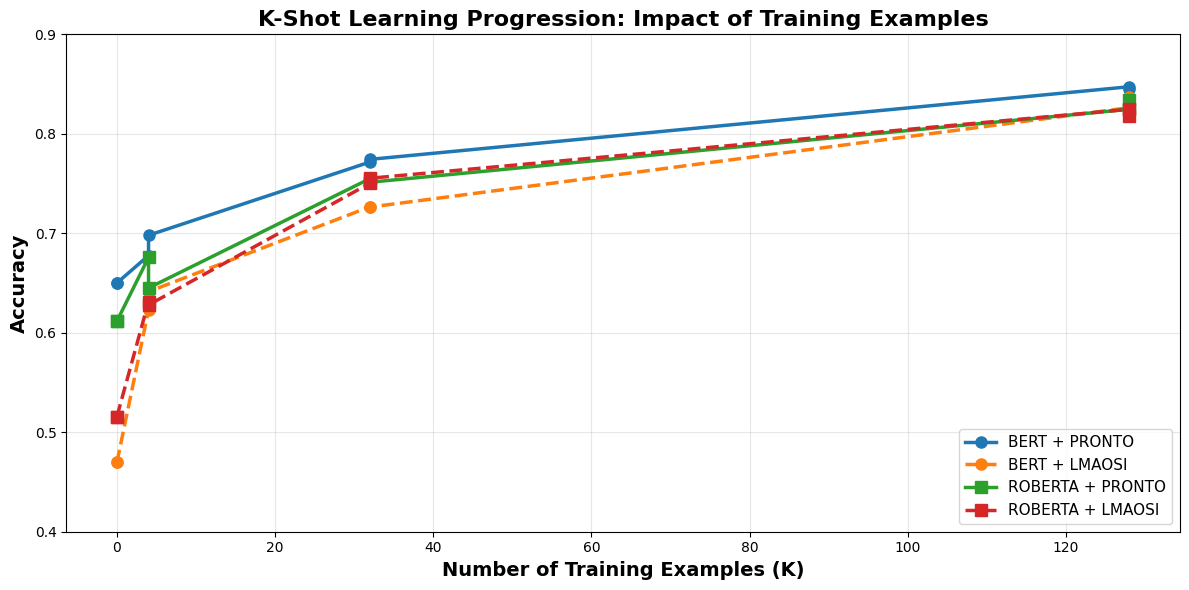

In [70]:
# =============================================================================
# 1. K-SHOT LEARNING PROGRESSION
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Filter k-shot data
kshot_phases = ['0-Shot PRONTO', '4-Shot PRONTO', '32-Shot PRONTO', '128-Shot PRONTO',
                '0-Shot LMAOSI', '4-Shot LMAOSI', '32-Shot LMAOSI', '128-Shot LMAOSI']
df_kshot = df_results[df_results['phase'].isin(kshot_phases)]

# Separate by model and prompt
for model_name in ['bert-base-uncased', 'roberta-base']:
    for prompt_style in ['PRONTO', 'LMAOSI']:
        data = df_kshot[(df_kshot['model'] == model_name) & 
                        (df_kshot['phase'].str.contains(prompt_style))]
        
        # Extract k values and sort
        data['k'] = data['phase'].str.extract(r'(\d+)-Shot').fillna(0).astype(int)
        data = data.sort_values('k')
        
        label = f"{model_name.split('-')[0].upper()} + {prompt_style}"
        linestyle = '-' if prompt_style == 'PRONTO' else '--'
        marker = 'o' if model_name == 'bert-base-uncased' else 's'
        
        ax.plot(data['k'].values, data['accuracy'].values, 
                label=label, linewidth=2.5, linestyle=linestyle, marker=marker, markersize=8)

ax.set_xlabel('Number of Training Examples (K)', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('K-Shot Learning Progression: Impact of Training Examples', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.4, 0.9)
plt.tight_layout()
plt.show()

2. **Verbalizer Impact**: PRONTO-MAV (non-linear automatic verbalizer) and PRONTO-VF (verbalizer-free) consistently outperform traditional linear mappings, achieving ~81-83% accuracy. This suggests that complex, learned projections better capture ontological semantics than hand-crafted verbalizers. The poor performance of PRONTO-WS (~48-57%) highlights the importance of proper verbalizer design.

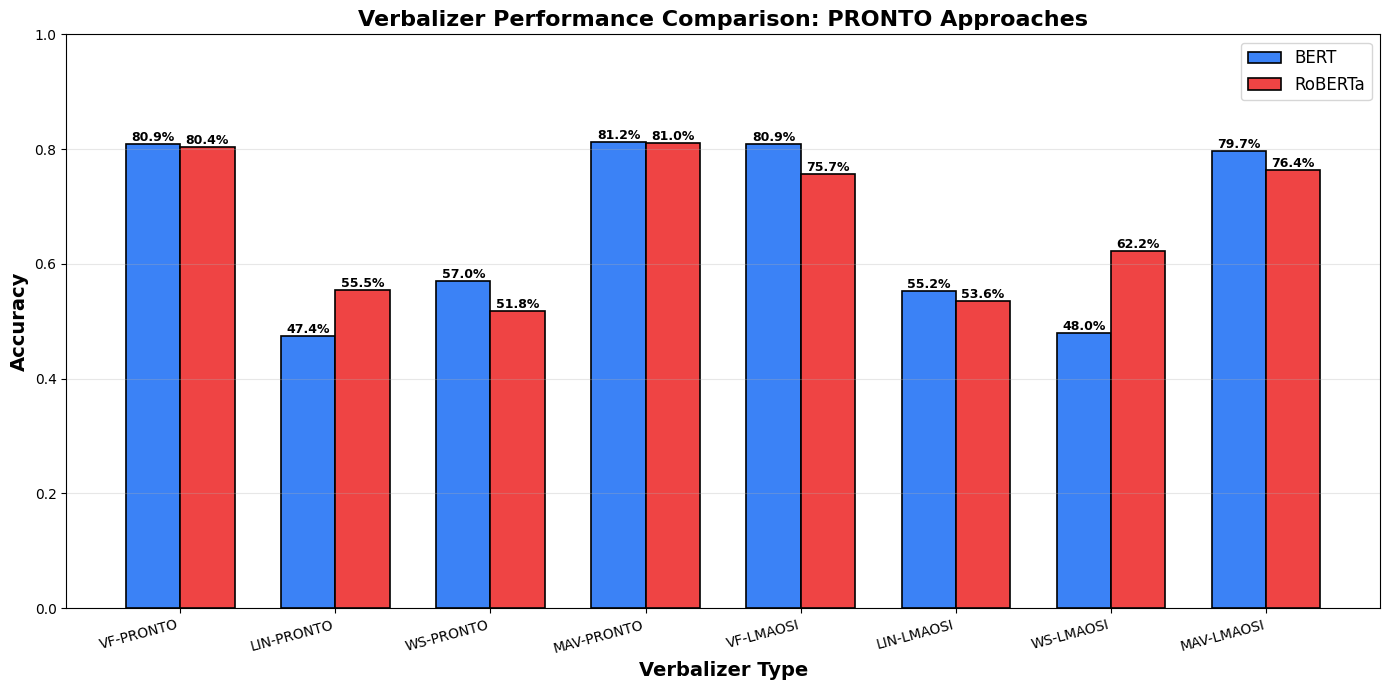

In [71]:
# =============================================================================
# 2. VERBALIZER COMPARISON
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 7))

# Filter verbalizer data
verbalizer_phases = [p for p in df_results['phase'].unique() 
                     if any(v in p for v in ['PRONTO-VF', 'PRONTO-LIN', 'PRONTO-WS', 'PRONTO-MAV'])]
df_verb = df_results[df_results['phase'].isin(verbalizer_phases)]

# Prepare data for grouped bar chart
verbalizers = df_verb['phase'].unique()
x = np.arange(len(verbalizers))
width = 0.35

bert_acc = [df_verb[(df_verb['phase'] == v) & (df_verb['model'] == 'bert-base-uncased')]['accuracy'].values[0] 
            for v in verbalizers]
roberta_acc = [df_verb[(df_verb['phase'] == v) & (df_verb['model'] == 'roberta-base')]['accuracy'].values[0] 
               for v in verbalizers]

bars1 = ax.bar(x - width/2, bert_acc, width, label='BERT', color='#3b82f6', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, roberta_acc, width, label='RoBERTa', color='#ef4444', edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Verbalizer Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Verbalizer Performance Comparison: PRONTO Approaches', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([v.replace('PRONTO-', '') for v in verbalizers], rotation=15, ha='right')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

Also from both previous grapsh we can evaluate that:

3. **Prompt Format Matters**: The PRONTO prompt format ("`<C>` is a [MASK] of `<D>`") generally yields better results than LMAOSI's interrogative format, particularly in 0-shot settings (65% vs 47% for BERT). This gap narrows with more training examples, suggesting that prompt engineering is especially crucial in low-resource scenarios. Yet even if the gap naroows with more trained verbalizers is still visible, higlithing how crucial prompt engineering when working with MLMs

4. **Model Comparison**: BERT slightly outperforms RoBERTa in most configurations, particularly with the PRONTO prompt, achieving a peak F1 of **84.5%** (128-shot) compared to RoBERTa's **83.5%** (MAV-PRONTO). However, RoBERTa shows more consistent performance across different verbalizers. This validates the hypotesis in PRONTO's paper that even if Bert has slightly less parameters than RoBerta it can still hold up in terms of results as it's training method helps it pass those type of tasks

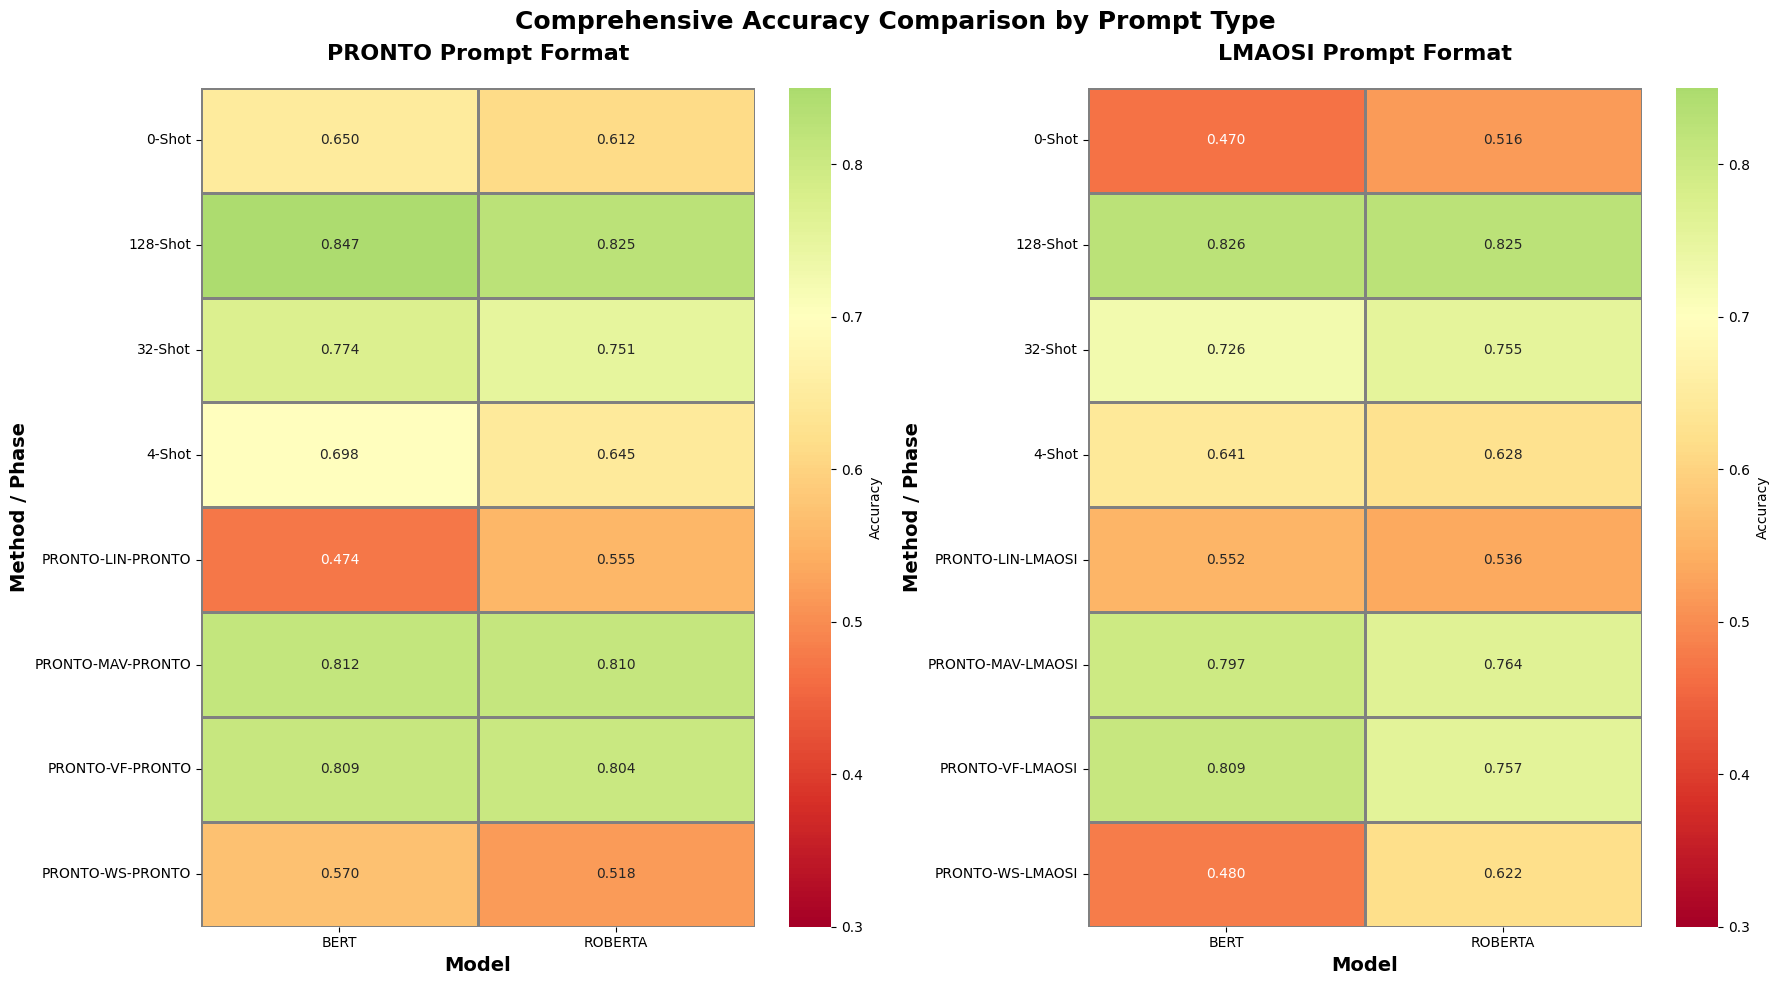

In [73]:
# =============================================================================
# 3 & 4. HEATMAP: COMPREHENSIVE COMPARISON
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Separate data by prompt type (based on last word in phase name)
df_pronto = df_results[df_results['phase'].str.endswith('PRONTO')]
df_lmaosi = df_results[df_results['phase'].str.endswith('LMAOSI')]

# Create pivot tables for each prompt type
pivot_pronto = df_pronto.pivot_table(
    values='accuracy', 
    index='phase', 
    columns='model', 
    aggfunc='first'
)

pivot_lmaosi = df_lmaosi.pivot_table(
    values='accuracy', 
    index='phase', 
    columns='model', 
    aggfunc='first'
)

# Clean up phase names (remove prompt type suffix)
pivot_pronto.index = [idx.replace(' PRONTO', '') for idx in pivot_pronto.index]
pivot_lmaosi.index = [idx.replace(' LMAOSI', '') for idx in pivot_lmaosi.index]

# Rename columns for clarity
for pivot in [pivot_pronto, pivot_lmaosi]:
    pivot.columns = [col.replace('-base-uncased', '').replace('-base', '').upper() 
                     for col in pivot.columns]

# Create PRONTO heatmap
sns.heatmap(pivot_pronto, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0.7, vmin=0.3, vmax=0.85,
            cbar_kws={'label': 'Accuracy'},
            linewidths=1, linecolor='gray',
            ax=ax1)

ax1.set_title('PRONTO Prompt Format', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('Method / Phase', fontsize=14, fontweight='bold')

# Create LMAOSI heatmap
sns.heatmap(pivot_lmaosi, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0.7, vmin=0.3, vmax=0.85,
            cbar_kws={'label': 'Accuracy'},
            linewidths=1, linecolor='gray',
            ax=ax2)

ax2.set_title('LMAOSI Prompt Format', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Model', fontsize=14, fontweight='bold')
ax2.set_ylabel('Method / Phase', fontsize=14, fontweight='bold')

# Overall title
fig.suptitle('Comprehensive Accuracy Comparison by Prompt Type', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

-----

### Methodological Insights:

**Best Overall Method**: strangely BERT + 128-Shot PRONTO (84.7% accuracy, 84.5% F1) / PRONTO-MAV consistently performs well across both models (~81-83% accuracy). Before running this experiment we expected BERT + MAV verbalizer to be the one that achieved best performances as in PRONTO's original paper this model reached over 90% yet, since we are using a completely different dataset from that paper it makes sense that results may vary.

Having BERT+128 shot as our best model implies to us that BOHT:

1) having few shots of training 
2) having a well structured verbalize

are both crucial in acheiving good results; validating key arguements of both ananyzed papers.

------

### Practical Implications:

**In conclusion**, both traditional k-shot verbalizers (LMAOSI approach) and automatic verbalizer learning (PRONTO approach) are viable strategies for ontology subsumption inference. The optimal choice depends on available resources:

- **K-shot learning** requires labeled examples but achieves great accuracy (84.7%), making it ideal when annotation resources are available
- **Automatic verbalizers** like PRONTO-MAV offer a good trade-off with 81-83% accuracy without extensive fine-tuning, suitable for scenarios with limited labeled data, as this study started with a dataset full of ONLY POSITIVE examples (like they had in the original PRONTO paper).
- **Verbalizer-free approaches** (PRONTO-VF) provide consistent results (~81%) and require minimal design effort

These results confirm that modern MLMs capture rich ontological structure beyond mere surface patterns, opening promising avenues for:
- Knowledge base completion
- Semantic reasoning tasks  
- Automated ontology enrichment
- Cross-lingual knowledge transfer

The success of these probing methods validates the hypothesis that pre-training on large text corpora enables models to internalize hierarchical conceptual relationships, making them valuable tools for knowledge-intensive NLP applications.